| **Scenario**                           | **Recommendation**                                      |
|----------------------------------------|----------------------------------------------------------|
| Using distance-based algorithms        | Scale all numeric features, including distinct ones, to ensure equal contribution to distance calculations. |
| Using tree-based algorithms             | No need to scale; tree-based algorithms are not sensitive to feature scales. |
| Using gradient boosting algorithms      | Scaling may be beneficial, though less critical than for distance-based algorithms. Experiment and evaluate impact on performance. |
| Maintaining ordinal relationship       | Consider normalization to a range between 0 and 1 instead of standard scaling. |
| Evaluating impact on model performance | Experiment with and without scaling; assess impact on metrics like accuracy, precision, recall, or F1 score. |


In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
6.774761830999978
GPU (s):
0.19589973199998667
GPU speedup over CPU: 34x


In [3]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
d = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Class/Fraud-Detection/Test-Zone/FD-Dataset.csv')
d

,V1CF,V2CF,V3CF,V4CF,V5CF,AreaCode,ConnectionOrg,ConnectionType,ConnectionSpeed,V6CF,...,EmailUpdateMonth,EmailUpdateYear,TransactionTimeOfDay,AddressUpdateTimeOfDay,EmailUpdateTimeOfDay,ConnectionOrg_freq_encoded,V6CF_freq_encoded,Region_freq_encoded,State_freq_encoded,Country_freq_encoded
0,99,98,10,803,19820,602.0,Others,cable,low,net.,...,10,2011,Evening,Morning,Afternoon,0.108143,0.537146,0.114098,0.096045,0.960006
1,99,94,61,602,16980,512.0,Others,cable,high,net.,...,9,2007,Morning,Afternoon,Evening,0.108143,0.537146,0.169052,0.154988,0.960006
2,76,95,66,505,35620,407.0,Others,cable,medium,net.,...,6,2012,Afternoon,Night,Night,0.108143,0.537146,0.058227,0.033663,0.960006
3,99,23,50,0,35620,202.0,Others,dsl,high,net.,...,12,2010,Afternoon,Afternoon,Afternoon,0.108143,0.537146,0.114098,0.034125,0.960006
4,99,74,80,602,19100,313.0,Others,cable,medium,net.,...,4,2009,Night,Afternoon,Afternoon,0.108143,0.537146,0.058227,0.033663,0.960006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138367,86,85,80,602,0,630.0,Others,tx,medium,US TLDs,...,10,2008,Morning,Morning,Afternoon,0.108143,0.003252,0.225891,0.188586,0.960006
138368,99,97,90,527,41860,630.0,Others,dsl,medium,net.,...,9,2011,Night,Night,Evening,0.108143,0.537146,0.117155,0.033641,0.960006
138369,99,88,90,618,12420,212.0,Others,cable,low,net.,...,9,2012,Night,Afternoon,Afternoon,0.108143,0.537146,0.216872,0.029153,0.960006
138370,99,23,23,819,16980,704.0,Others,tx,medium,com.,...,5,2008,Morning,Night,Night,0.108143,0.290369,0.216872,0.152307,0.960006


In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138372 entries, 0 to 138371
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   V1CF                        138372 non-null  int64  
 1   V2CF                        138372 non-null  int64  
 2   V3CF                        138372 non-null  int64  
 3   V4CF                        138372 non-null  int64  
 4   V5CF                        138372 non-null  int64  
 5   AreaCode                    138372 non-null  float64
 6   ConnectionOrg               138372 non-null  object 
 7   ConnectionType              138372 non-null  object 
 8   ConnectionSpeed             138372 non-null  object 
 9   V6CF                        138372 non-null  object 
 10  channel                     138372 non-null  object 
 11  webSessOS                   138372 non-null  object 
 12  webSessWebBrowser           138372 non-null  object 
 13  IsOldDevice   

In [6]:
d.nunique().sort_values(ascending = False)

MainEntityUse                 937
V5CF                          582
AreaCode                      254
V4CF                          207
ConnectionOrg                  46
ConnectionOrg_freq_encoded     45
State                          43
State_freq_encoded             41
EmailUpdateDay                 31
AddressUpdateDay               31
TransactionDay                 31
V2CF                           29
AddressUpdateYear              29
V3CF                           23
Country                        16
Country_freq_encoded           16
Region                         13
Region_freq_encoded            13
V6CF_freq_encoded              13
EmailUpdateYear                13
V6CF                           13
AddressUpdateMonth             12
EmailUpdateMonth               12
ConnectionType                 10
V1CF                            9
webSessOS                       8
webSessWebBrowser               8
TransactionMonth                6
channel                         4
TransactionTim

In [7]:
objects = d.select_dtypes(include=['object']).columns.tolist()
objects

['ConnectionOrg',
 'ConnectionType',
 'ConnectionSpeed',
 'V6CF',
 'channel',
 'webSessOS',
 'webSessWebBrowser',
 'Region',
 'State',
 'Country',
 'TransactionTimeOfDay',
 'AddressUpdateTimeOfDay',
 'EmailUpdateTimeOfDay']

In [8]:
d.select_dtypes(include=['object']).nunique().sort_values(ascending = False)

ConnectionOrg             46
State                     43
Country                   16
V6CF                      13
Region                    13
ConnectionType            10
webSessOS                  8
webSessWebBrowser          8
ConnectionSpeed            4
channel                    4
TransactionTimeOfDay       4
AddressUpdateTimeOfDay     4
EmailUpdateTimeOfDay       4
dtype: int64

In [9]:
cols = ['ConnectionOrg', 'State', 'Country', 'V6CF', 'Region']
d.drop(columns = cols, inplace = True)

In [10]:
d['IsOldDevice'].value_counts()

1.0    109607
0.0     24712
1.5      4053
Name: IsOldDevice, dtype: int64

In [11]:
d['DeviceCategory'] = np.where(d['IsOldDevice'] == 1.0, 'Old_Device',
                               np.where(d['IsOldDevice'] == 0.0, 'Not_Old_Device',
                                        np.where(d['IsOldDevice'] == 1.5, 'Either', 'Special_Category')))
d.drop(columns='IsOldDevice', inplace=True)

In [12]:
d['DeviceCategory'].value_counts()

Old_Device        109607
Not_Old_Device     24712
Either              4053
Name: DeviceCategory, dtype: int64

In [13]:
objects = d.select_dtypes(include=['object']).columns.tolist()
print(objects)
dummies = pd.get_dummies(d[objects])
d = pd.concat([d, dummies], axis=1)
d = d.drop(objects, axis=1)

['ConnectionType', 'ConnectionSpeed', 'channel', 'webSessOS', 'webSessWebBrowser', 'TransactionTimeOfDay', 'AddressUpdateTimeOfDay', 'EmailUpdateTimeOfDay', 'DeviceCategory']


In [14]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138372 entries, 0 to 138371
Data columns (total 70 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   V1CF                                 138372 non-null  int64  
 1   V2CF                                 138372 non-null  int64  
 2   V3CF                                 138372 non-null  int64  
 3   V4CF                                 138372 non-null  int64  
 4   V5CF                                 138372 non-null  int64  
 5   AreaCode                             138372 non-null  float64
 6   MainEntityUse                        138372 non-null  float64
 7   Fraud                                138372 non-null  int64  
 8   TransactionDay                       138372 non-null  int64  
 9   TransactionMonth                     138372 non-null  int64  
 10  AddressUpdateDay                     138372 non-null  int64  
 11  AddressUpdate

| **Machine Learning Algorithm**       | **Frequency Encoding**                                     | **One-Hot Encoding**                                        | **Comments**                                                                         |
| ----------------------------------- | ------------------------------------------------------------ | ------------------------------------------------------------ | ------------------------------------------------------------------------------------- |
| Tree-Based Models (e.g., XGBoost)   | May be beneficial, especially if frequency contains meaningful information. | Often not necessary. Trees can handle categorical variables without one-hot encoding. | Check the impact on model performance.                                              |
| Linear Models (e.g., Logistic Regression) | Frequency encoding may not be effective. One-hot encoding is typically required. | Required for linear models as they interpret categorical variables differently.       | One-hot encoding is the standard practice.                                         |
| Neural Networks                     | One-hot encoding is generally preferred.                    | One-hot encoding is commonly used in neural networks.       | Allows the model to learn complex relationships between categories.                  |
| K-Nearest Neighbors (KNN)           | Frequency encoding may distort distances. One-hot encoding is often preferred. | One-hot encoding is commonly used in KNN.                    | Distances are sensitive, and one-hot encoding preserves them better.                  |
| Support Vector Machines (SVM)       | One-hot encoding is generally required.                      | Required for SVMs.                                          | SVMs rely on the dot product of feature vectors, and one-hot encoding is appropriate. |
| General Recommendation               | Experiment with both encoding methods and evaluate model performance. | Use one-hot encoding for linear models and models that rely on distances. | Consider the cardinality of categorical variables and dataset size.                   |

In [15]:
d.loc[:, 'V1CF':'EmailUpdateYear']

,V1CF,V2CF,V3CF,V4CF,V5CF,AreaCode,MainEntityUse,Fraud,TransactionDay,TransactionMonth,AddressUpdateDay,AddressUpdateMonth,AddressUpdateYear,EmailUpdateDay,EmailUpdateMonth,EmailUpdateYear
0,99,98,10,803,19820,602.0,351.003332,0,23,5,21,8,2004,14,10,2011
1,99,94,61,602,16980,512.0,315.000000,0,27,5,24,8,2010,6,9,2007
2,76,95,66,505,35620,407.0,333.000000,0,23,5,26,3,2013,20,6,2012
3,99,23,50,0,35620,202.0,327.000000,0,31,5,7,6,2009,13,12,2010
4,99,74,80,602,19100,313.0,394.000000,0,1,6,9,5,2012,20,4,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138367,86,85,80,602,0,630.0,406.000000,0,26,5,1,11,2005,15,10,2008
138368,99,97,90,527,41860,630.0,360.000000,0,22,5,7,2,2003,21,9,2011
138369,99,88,90,618,12420,212.0,240.000000,0,31,5,16,4,2011,14,9,2012
138370,99,23,23,819,16980,704.0,395.000000,0,26,5,19,4,2012,27,5,2008


In [16]:
from sklearn.preprocessing import MinMaxScaler
cols = ['TransactionDay', 'TransactionMonth', 'AddressUpdateDay', 'AddressUpdateMonth', 'AddressUpdateYear', 'EmailUpdateDay', 'EmailUpdateMonth', 'EmailUpdateYear']
scaler = MinMaxScaler()
d[cols] = scaler.fit_transform(d[cols])

In [17]:
cols = d.loc[:, 'V1CF':'MainEntityUse'].columns

In [18]:
d[cols] = scaler.fit_transform(d[cols])

In [19]:
# d.describe().T.head(60)

In [20]:
# !pip install tensorflow
# !pip install keras

In [21]:
from sklearn.model_selection import train_test_split
X =  d.drop('Fraud', axis = 1)
y = d['Fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
def get_recall_score(model):

    pred_train=model.predict(X_train)
    pred_test=model.predict(X_test)
    res1 = print("Recall on training set : ", metrics.recall_score(y_train, pred_train))
    res2 = print("Recall on test set :", metrics.recall_score(y_test, pred_test))

In [23]:
print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
print(f"\nShape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")

Shape of X_train: (110697, 69), Shape of y_train: (110697,)

Shape of X_test: (27675, 69), Shape of y_test: (27675,)


In [24]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f"Shape of X_resampled: {X_resampled.shape}, Shape of y_resampled: {y_resampled.shape}")

Shape of X_resampled: (215054, 69), Shape of y_resampled: (215054,)


In [25]:
# !pip install imblearn
# !pip install imbalanced-learn

In [26]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

### Random-Under-Sampling

In [27]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [28]:
print(f"Shape of X_resampled: {X_rus.shape}, Shape of y_resampled: {y_rus.shape}")

Shape of X_resampled: (6340, 69), Shape of y_resampled: (6340,)


In [29]:
models = [
    LogisticRegression(),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    XGBClassifier(),
    DecisionTreeClassifier(random_state=42),
    BalancedBaggingClassifier(n_estimators=50, random_state=42),
    EasyEnsembleClassifier(n_estimators=50, random_state=42),
    SVC(random_state=42, probability=True),
    KNeighborsClassifier(n_neighbors=5),
]

for model in models:
    model.fit(X_rus, y_rus)

    y_pred_train = model.predict(X_rus)
    recall_train = recall_score(y_rus, y_pred_train)
    precision_train = precision_score(y_rus, y_pred_train)
    accuracy_train = accuracy_score(y_rus, y_pred_train)

    y_pred_test = model.predict(X_test)
    recall_test = recall_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    print(f"\nResults for {model.__class__.__name__} using Random Under Sampling:")
    print(f"Train Accuracy: {round(accuracy_train, 4) * 100}%")
    print(f"Test Accuracy: {round(accuracy_test, 4) * 100}%")

    print(f"Train Recall: {round(recall_train, 4) * 100}%")
    print(f"Test Recall: {round(recall_test, 4) * 100}%")

    print(f"Train Precision: {round(precision_train, 4) * 100}%")
    print(f"Test Precision: {round(precision_test, 4) * 100}%")

    print(f"\nClassification Report for {model.__class__.__name__}:\n")
    print(classification_report(y_test, y_pred_test))
    print("="*55)


Results for LogisticRegression using Random Under Sampling:
Train Accuracy: 53.03%
Test Accuracy: 50.980000000000004%
Train Recall: 51.51%
Test Recall: 46.410000000000004%
Train Precision: 53.12%
Test Precision: 2.68%

Classification Report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.97      0.51      0.67     26895
           1       0.03      0.46      0.05       780

    accuracy                           0.51     27675
   macro avg       0.50      0.49      0.36     27675
weighted avg       0.94      0.51      0.65     27675


Results for RandomForestClassifier using Random Under Sampling:
Train Accuracy: 100.0%
Test Accuracy: 52.38%
Train Recall: 100.0%
Test Recall: 48.97%
Train Precision: 100.0%
Test Precision: 2.9000000000000004%

Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.97      0.52      0.68     26895
           1       0.03      0.49 

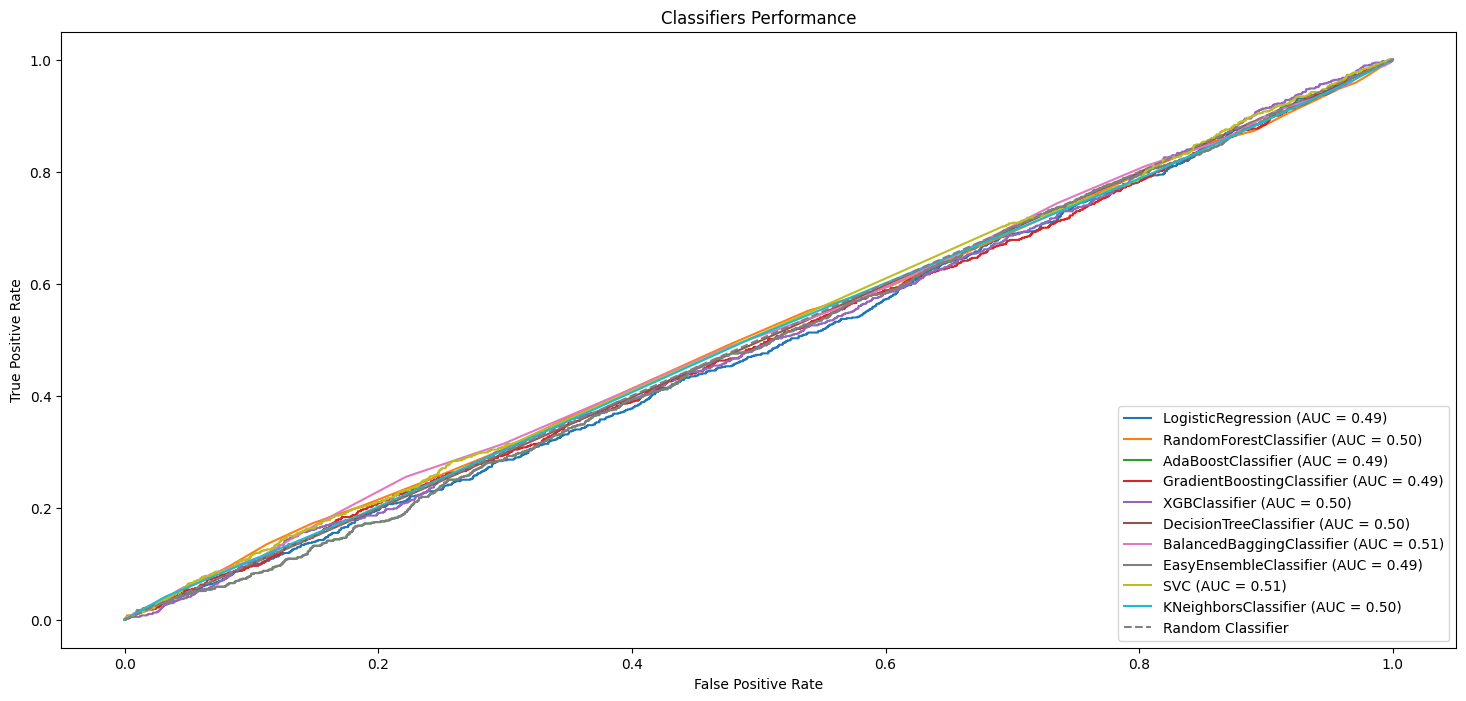

In [30]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(18, 8))

for model in models:
    model.fit(X_rus, y_rus)

    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('Classifiers Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

### Random-Over-Sampling

In [31]:
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

In [32]:
print(f"Shape of X_resampled: {X_ros.shape}, Shape of y_resampled: {y_ros.shape}")

Shape of X_resampled: (268844, 69), Shape of y_resampled: (268844,)


In [33]:
models = [
    LogisticRegression(),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    XGBClassifier(),
    DecisionTreeClassifier(random_state=42),
    # BalancedBaggingClassifier(n_estimators=50, random_state=42),
    # EasyEnsembleClassifier(n_estimators=50, random_state=42)
    # SVC(random_state=42),
    # KNeighborsClassifier(n_neighbors=5),
]

for model in models:
    model.fit(X_ros, y_ros)

    y_pred_train = model.predict(X_ros)
    recall_train = recall_score(y_ros, y_pred_train)
    precision_train = precision_score(y_ros, y_pred_train)
    accuracy_train = accuracy_score(y_ros, y_pred_train)

    y_pred_test = model.predict(X_test)
    recall_test = recall_score(y_test, y_pred_test)
    precision_test = precision_score(y_test, y_pred_test)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    print(f"\nResults for {model.__class__.__name__} using Random Over Sampling:")
    print(f"Train Accuracy: {round(accuracy_train, 4) * 100}%")
    print(f"Test Accuracy: {round(accuracy_test, 4) * 100}%")

    print(f"Train Recall: {round(recall_train, 4) * 100}%")
    print(f"Test Recall: {round(recall_test, 4) * 100}%")

    print(f"Train Precision: {round(precision_train, 4) * 100}%")
    print(f"Test Precision: {round(precision_test, 4) * 100}%")

    print(f"\nClassification Report for {model.__class__.__name__}:\n")
    print(classification_report(y_test, y_pred_test))
    print("="*55)


Results for LogisticRegression using Random Over Sampling:
Train Accuracy: 52.38%
Test Accuracy: 52.910000000000004%
Train Recall: 51.72%
Test Recall: 53.459999999999994%
Train Precision: 52.410000000000004%
Test Precision: 3.19%

Classification Report for LogisticRegression:

              precision    recall  f1-score   support

           0       0.98      0.53      0.69     26895
           1       0.03      0.53      0.06       780

    accuracy                           0.53     27675
   macro avg       0.50      0.53      0.37     27675
weighted avg       0.95      0.53      0.67     27675


Results for RandomForestClassifier using Random Over Sampling:
Train Accuracy: 100.0%
Test Accuracy: 100.0%
Train Recall: 100.0%
Test Recall: 100.0%
Train Precision: 100.0%
Test Precision: 100.0%

Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26895
           1       1.00      1.00   

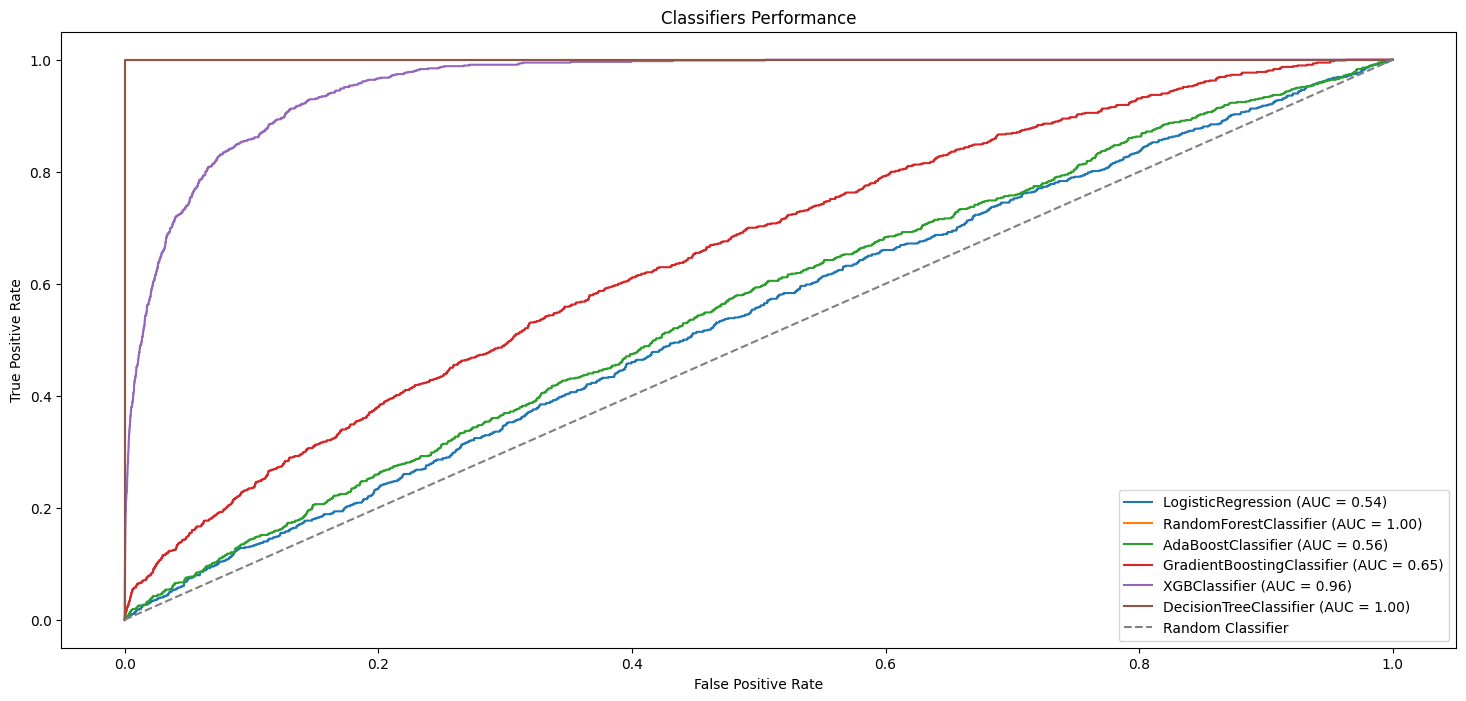

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
plt.figure(figsize=(18, 8))

for model in models:
    model.fit(X_ros, y_ros)

    y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.title('Classifiers Performance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [35]:
# !pip install optuna
# import optuna
# from optuna.samplers import TPESampler
# from sklearn.metrics import make_scorer
# def objective(trial):
#     param = {
#         'objective': 'binary:logistic',
#         'eval_metric': 'auc',
#         'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
#         'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
#         'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
#         'max_depth': trial.suggest_int('max_depth', 1, 10),
#         'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
#         'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#     }

#     model = XGBClassifier(**param)
#     scoring_function = make_scorer(lambda y_true, y_pred, **kwargs: (
#         accuracy_score(y_true, y_pred) +
#         precision_score(y_true, y_pred) +
#         recall_score(y_true, y_pred) +
#         f1_score(y_true, y_pred)) / 4.0, greater_is_better=True)

#     cv_score = cross_val_score(model, X_ros, y_ros, cv=5, scoring=scoring_function)

# study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
# study.optimize(objective, n_trials=150)
# best_params = study.best_params
# print(f"Best Parameters: {best_params}")
# best_params = study.best_params
# final_model = XGBClassifier(**best_params)
# final_model.fit(X_train, y_train)

# Best Parameters_1: {'booster': 'gbtree', 'max_depth': 10, 'eta': 0.08070164326683693, 'subsample': 0.5095961641747717, 'colsample_bytree': 0.7531084034208448, 'min_child_weight': 1}

In [36]:
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import RandomizedSearchCV
# xgb = XGBClassifier()
# param_dist = {
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
#     'min_child_weight': [1, 2, 3, 4, 5],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'gamma': [0, 0.1, 0.2, 0.3, 0.4],
#     'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4],
#     'reg_lambda': [0.5, 0.7, 0.9, 1.0],
#     'scale_pos_weight': [1, 2, 3, 4, 5]
# }

# scoring_metric = 'precision'
# random_search = RandomizedSearchCV(
#     xgb,
#     param_distributions=param_dist,
#     n_iter=10,
#     scoring=make_scorer(scoring_metric),
#     n_jobs=-1,
#     cv=5,
#     random_state=42)

# random_search.fit(X_ros, y_ros)
# best_params = random_search.best_params_
# print("Best Parameters:", best_params)
# final = random_search.best_estimator_
# final_model = random_search.best_estimator_

Results for XGBClassifier using Random Over Sampling + RandomSearchCV:
- Train Accuracy: 55.2%
- Test Accuracy: 12.889999999999999%
- Train Recall: 100.0%
- Test Recall: 100.0%
- Train Precision: 52.739999999999995%
- Test Precision: 3.1300000000000003%

Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       1.00      0.10      0.19     26895
           1       0.03      1.00      0.06       780

    accuracy                           0.13     27675
    macro avg      0.52      0.55      0.12     27675
    weighted avg   0.97      0.13      0.18     27675

In [37]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/Class/Fraud-Detection/Test-Zone/xgboostclf_optuna.pkl', 'rb') as file:
    final_model = pickle.load(file)

In [38]:
y_pred_train = final_model.predict(X_ros)
recall_train = recall_score(y_ros, y_pred_train)
precision_train = precision_score(y_ros, y_pred_train)
accuracy_train = accuracy_score(y_ros, y_pred_train)

y_pred_test = final_model.predict(X_test)
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f"\nResults for {final_model.__class__.__name__} using Random Over Sampling + Optuna:")
print(f"Train Accuracy: {round(accuracy_train, 4) * 100}%")
print(f"Test Accuracy: {round(accuracy_test, 4) * 100}%")

print(f"Train Recall: {round(recall_train, 4) * 100}%")
print(f"Test Recall: {round(recall_test, 4) * 100}%")

print(f"Train Precision: {round(precision_train, 4) * 100}%")
print(f"Test Precision: {round(precision_test, 4) * 100}%")

print(f"\nClassification Report for {final_model.__class__.__name__}:\n")
print(classification_report(y_test, y_pred_test))


Results for XGBClassifier using Random Over Sampling + Optuna:
Train Accuracy: 98.8%
Test Accuracy: 98.05%
Train Recall: 99.56%
Test Recall: 99.74%
Train Precision: 98.07000000000001%
Test Precision: 59.07%

Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26895
           1       0.59      1.00      0.74       780

    accuracy                           0.98     27675
   macro avg       0.80      0.99      0.87     27675
weighted avg       0.99      0.98      0.98     27675



In [39]:
y_pred_train = final_model.predict(X_rus)
recall_train = recall_score(y_rus, y_pred_train)
precision_train = precision_score(y_rus, y_pred_train)
accuracy_train = accuracy_score(y_rus, y_pred_train)

y_pred_test = final_model.predict(X_test)
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f"\nResults for {final_model.__class__.__name__} using Random Under Sampling + Optuna:")
print(f"Train Accuracy: {round(accuracy_train, 4) * 100}%")
print(f"Test Accuracy: {round(accuracy_test, 4) * 100}%")

print(f"Train Recall: {round(recall_train, 4) * 100}%")
print(f"Test Recall: {round(recall_test, 4) * 100}%")

print(f"Train Precision: {round(precision_train, 4) * 100}%")
print(f"Test Precision: {round(precision_test, 4) * 100}%")

print(f"\nClassification Report for {final_model.__class__.__name__}:\n")
print(classification_report(y_test, y_pred_test))


Results for XGBClassifier using Random Under Sampling + Optuna:
Train Accuracy: 98.71%
Test Accuracy: 98.05%
Train Recall: 99.42999999999999%
Test Recall: 99.74%
Train Precision: 98.00999999999999%
Test Precision: 59.07%

Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26895
           1       0.59      1.00      0.74       780

    accuracy                           0.98     27675
   macro avg       0.80      0.99      0.87     27675
weighted avg       0.99      0.98      0.98     27675



In [40]:
y_pred_train = final_model.predict(X_train)
recall_train = recall_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
accuracy_train = accuracy_score(y_train, y_pred_train)

y_pred_test = final_model.predict(X_test)
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f"\nResults for {final_model.__class__.__name__} using normal data + Optuna:")
print(f"Train Accuracy: {round(accuracy_train, 4) * 100}%")
print(f"Test Accuracy: {round(accuracy_test, 4) * 100}%")

print(f"Train Recall: {round(recall_train, 4) * 100}%")
print(f"Test Recall: {round(recall_test, 4) * 100}%")

print(f"Train Precision: {round(precision_train, 4) * 100}%")
print(f"Test Precision: {round(precision_test, 4) * 100}%")

print(f"\nClassification Report for {final_model.__class__.__name__}:\n")
print(classification_report(y_test, y_pred_test))


Results for XGBClassifier using normal data + Optuna:
Train Accuracy: 98.09%
Test Accuracy: 98.05%
Train Recall: 99.42999999999999%
Test Recall: 99.74%
Train Precision: 60.050000000000004%
Test Precision: 59.07%

Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26895
           1       0.59      1.00      0.74       780

    accuracy                           0.98     27675
   macro avg       0.80      0.99      0.87     27675
weighted avg       0.99      0.98      0.98     27675



In [41]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print(f"Shape of X_resampled: {X_smote.shape}, Shape of y_resampled: {y_smote.shape}")

y_pred_train = final_model.predict(X_smote)
recall_train = recall_score(y_smote, y_pred_train)
precision_train = precision_score(y_smote, y_pred_train)
accuracy_train = accuracy_score(y_smote, y_pred_train)

y_pred_test = final_model.predict(X_test)
recall_test = recall_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f"\nResults for {final_model.__class__.__name__} using SMOTE data + Optuna:")
print(f"Train Accuracy: {round(accuracy_train, 4) * 100}%")
print(f"Test Accuracy: {round(accuracy_test, 4) * 100}%")

print(f"Train Recall: {round(recall_train, 4) * 100}%")
print(f"Test Recall: {round(recall_test, 4) * 100}%")

print(f"Train Precision: {round(precision_train, 4) * 100}%")
print(f"Test Precision: {round(precision_test, 4) * 100}%")

print(f"\nClassification Report for {final_model.__class__.__name__}:\n")
print(classification_report(y_test, y_pred_test))

Shape of X_resampled: (215054, 69), Shape of y_resampled: (215054,)

Results for XGBClassifier using SMOTE data + Optuna:
Train Accuracy: 62.129999999999995%
Test Accuracy: 98.05%
Train Recall: 26.22%
Test Recall: 99.74%
Train Precision: 93.08%
Test Precision: 59.07%

Classification Report for XGBClassifier:

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26895
           1       0.59      1.00      0.74       780

    accuracy                           0.98     27675
   macro avg       0.80      0.99      0.87     27675
weighted avg       0.99      0.98      0.98     27675



In [42]:
# import pickle
# with open('xgboostclf_optuna_3.pkl', 'wb') as file:
#     pickle.dump(final_model, file)

# To load the model later
# with open('best_model_xgboost.pkl', 'rb') as file:
#     loaded_model = pickle.load(file)